ROS 2 Foxy 버전 기준으로 Lifecycle 은 rclcpp 를 통해서만 사용가능 하다. 데모 코는 Lifecycle 이 적용된 노드(lc_talker) 와 lc_talker 에서 발간하는 정보와 주요 상태를 구독하는 노드(lc_listener) 그리고 lc_talker 의 현재 주요 상태를 확인하고 다른 주요 상태로 전환시켜주는 노드(lc_client) 로 구성되어 있다.

# lc_talker

demos/lifecycle/src/lifecycle_talker.cpp

먼저 LifecycleTalker 클래스 선언 부분을 살펴보자. 기존에는 rclcpp::Node 클래스를 상속 받아 노드를 개발하였지만 Lifecycle 을 사용하기 위해서는 rclcpp_lifecycle::LifecycleNode 클래스를 상속받아야 한다. 생성자를 살펴보면 상속받은 부모 클래스를 초기화 해주는 부분이 rclcpp::Node 클래스를 초기화 해주었던 방법과 동일하다는 것을 확인할 수 있다. 이처럼 ROS 2 에서는 추가 기능을 사용하기 위한 코드가 기본 노드 생성 코드에서 크게 벗어나지 않기 때문에 확장성이 매우 좋다.

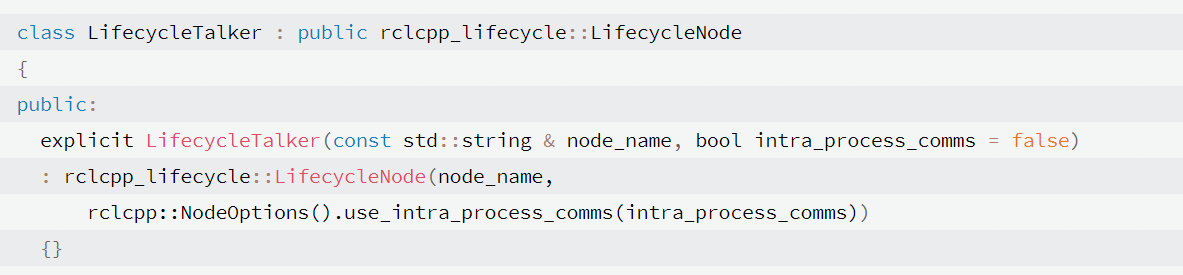

다음은 Lifecycle 에서 정의한 전환 상태에서 노드가 어떤 동작을 해야하는지 설정해주는 부분을 살펴보도록 하자. 해당 부분에는 사용자 코드가 포함된다.

on_configure 함수에는 Unconfigure 상태에서 Inactivate 상태로 전환되는 전환 상태에서 필요한 동작을 구현해주어야 한다. 아래 함수를 보면 메시지를 발간하기 위한 lifecycle publisher 와 wall_timer 를 인스턴스화 하는 코드를 확인할 수 있고, 함수 리턴 값을 통해 그 성공과 실패를 전달할 수 있다. 만약 성공한다면 Inactivate 상태로 전환될 것이고, 그렇지 않다면 Unconfigure 상태에 머무를 것이다. 에러가 발생하면 ErrorProcessing 전환상태가 불려진다.

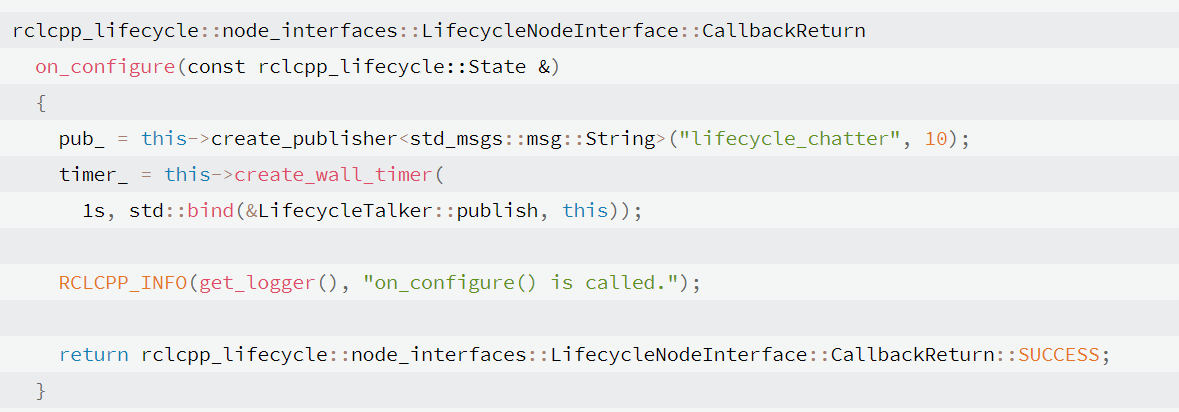

on_activate 함수에는 Inactivate 상태에서 Activate 상태로 전환되는 전환 상태에서 필요한 과정을 구현한다. rclcpp_lifecycle::LifecyclePublisher 는 기존에 노드에서 사용했던 publisher 를 제어할 수 있는 함수가 추가되어 있어 이를 꼭 불러줘야만 한다. on_activate 콜백 결과 Activate 상태에서 publisher 가 동작되어야 하기 때문에 on_activate() 함수가 코드에 포함되어 있는 것을 확인할 수 있다.

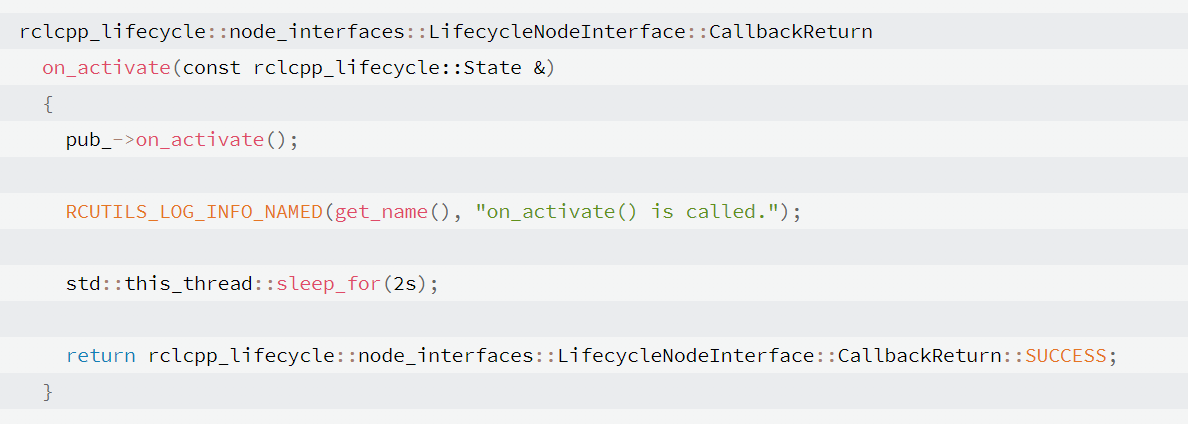

on_deactivate 함수에는 Activate 상태에서 Inactivate 상태로 전환되는 전환 상태에서 필요한 과정을 구현한다. on_deactivate 콜백 결과 Inactivate 상태에서 publisher 가 동작을 멈춰야 하기 때문에 on_deactivate() 함수가 코드에 포함되어 있는 것을 확인할 수 있다.

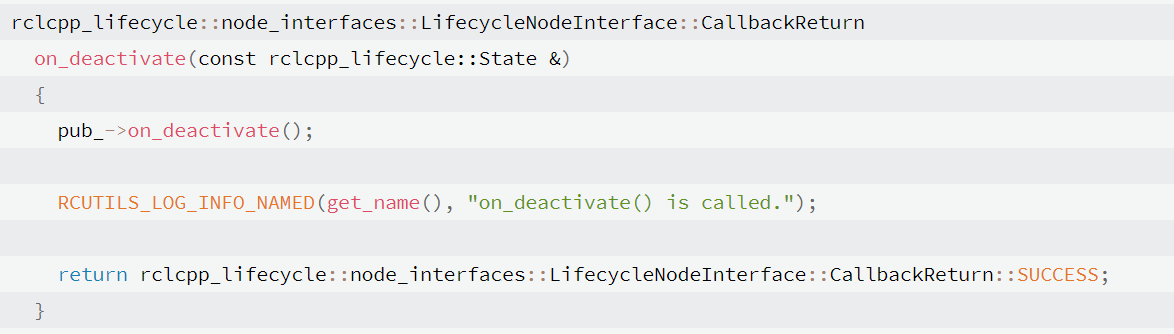

on_cleanup 함수에는 Inactivate 상태에서 Unconfigure 상태로 전환되는 전환 상태에서 필요한 과정을 구현한다. 아래 코드를 보면 timer 와 publisher 를 초기화 하는 것을 확인할 수 있다.

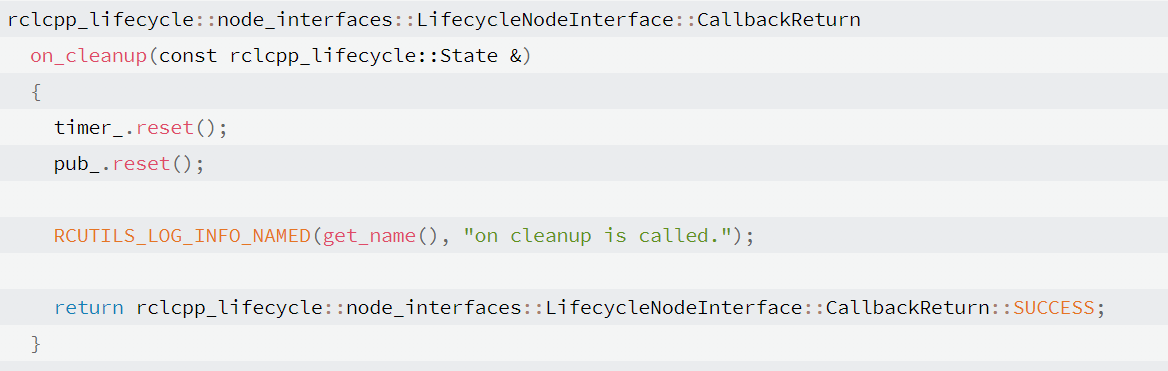

on_shutdown 함수에는 노드를 파괴시키기 전에 필요한 과정을 구현한다. rclcpp_lifecycle::State 매개변수를 통해 어느 주요 상태로 부터 불려진건지 확인할 수도 있다.

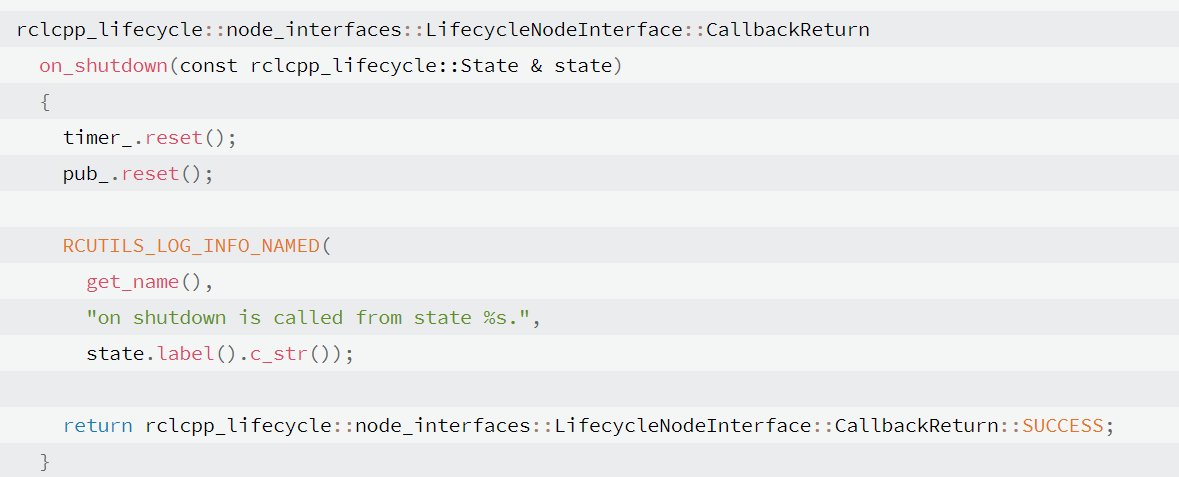

# lc_listener

demos/lifecycle/src/lifecycle_listener.cpp

LifecycleListener 클래스는 Lifecycle 이 적용되지 않은 rclcpp::Node 클래스를 상속 받는다. 해당 클래스에는 두개의 subscriber 가 선언되어 있는데 하나는 lc_talker 에서 보내주는 데이터를 구독하는 것이고, 다른 하나는 lc_talker 의 상태 전환 이벤트를 구독하여 이전 주요 상태와 전환된 주요 상태를 보여줄 것이다. Lifecycle 과 연관된 토픽은 앞에 노드 네임이 네임스페이스로 붙어있어 다른 토픽과 겹치지 않는다.

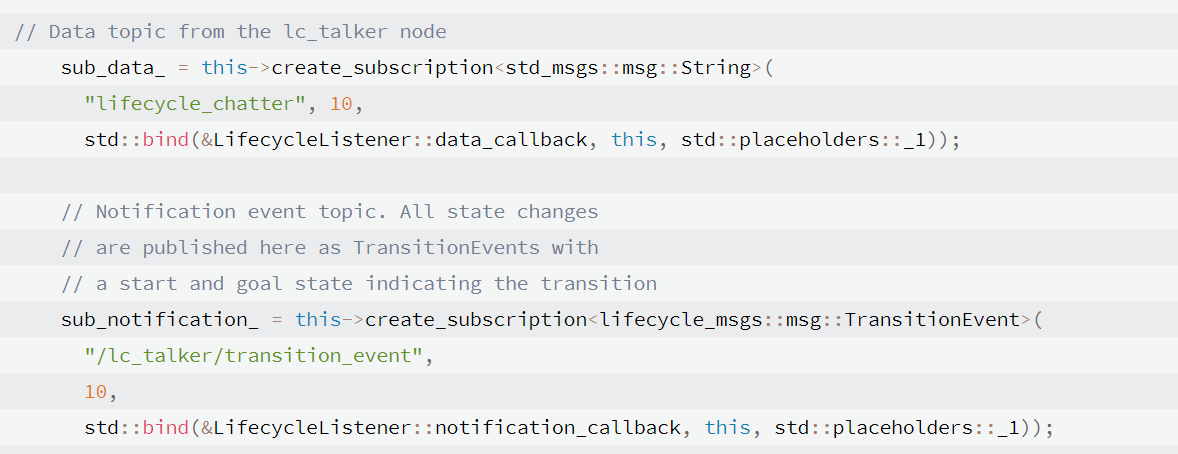

# lc_client

demos/lifecycle/src/lifecycle_service_client.cpp

Lifecycle 인터페이스는 서비스 서버를 제공하여 개발자가 서비스 클라이언트를 통해 쉽게 노드를 상태를 확인하고 전환할 수 있도록 하였다. 서비스의 이름은 Lifecycle 노드의 이름 뒤에 원하는 기능을 더한 형태이다.

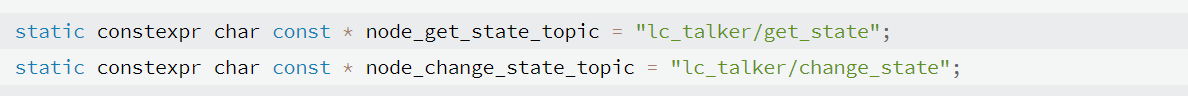

get_state 함수를 보면 lifecycle_msgs::srv::GetState 타입의 서비스 클라이언트를 이용해서 현재 주요 상태를 확인하는 코드를 볼 수 있다.

change_state 함수를 통해 transition 매개변수와 lifecycle_msgs::srv::ChangeState 타입의 서비스 클라이언트를 이용해서 노드의 주요 상태를 전환할 수 있는 코드를 확인할 수 있다.

참고로 CMakeLists.txt 에는 rclcpp 뿐만 아니라 rclcpp_lifecycle 패키지도 포함시켜줘야 한다는 것 잊지말자.

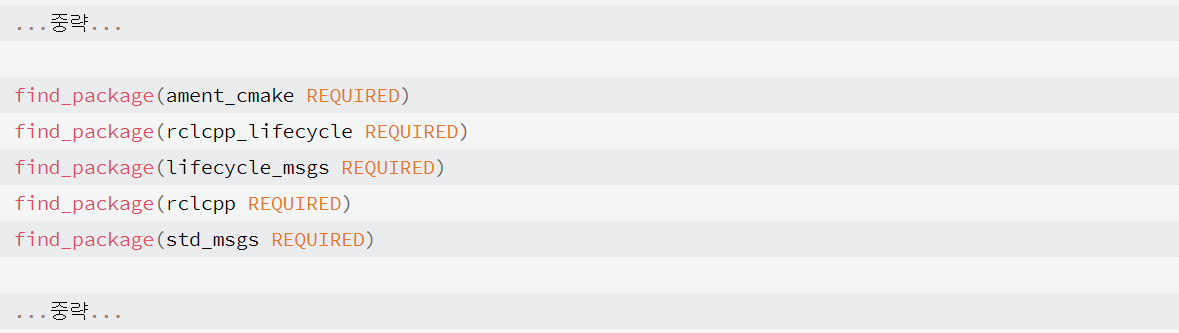

이제 코드는 모두 살펴 보았으니 아래 명령어로 해당 노드들을 하나씩 실행 시켜 보자.

In [ ]:
ros2 run lifecycle lifecycle_talker
ros2 run lifecycle lifecycle_listener
ros2 run lifecycle lifecycle_service_client

만약 한번에 실행시키고 싶다면 아래 launch 명령어를 사용해도 된다.

In [ ]:
ros2 launch lifecycle lifecycle_demo.launch.py

lc_talker 와 lc_listener 를 단독으로 실행시켰을 때는 터미널 창에 아무런 로그를 확인할 수 없다. Lifecycle 인터페이스를 가지고 있는 lc_talker 노드는 생성자에 아무런 코드가 포함되어 있지 않기 때문에 상태 전환을 통해서만 동작시킬 수 있다. lc_client 노드를 실행 시키면 그때 부터 lc_talker 의 상태가 Configure -> Inactivate -> Activate -> Inactivate -> Activate -> Inactivate -> Finalized 순서로 전환되어 아래와 같은 로그를 확인할 수 있다.

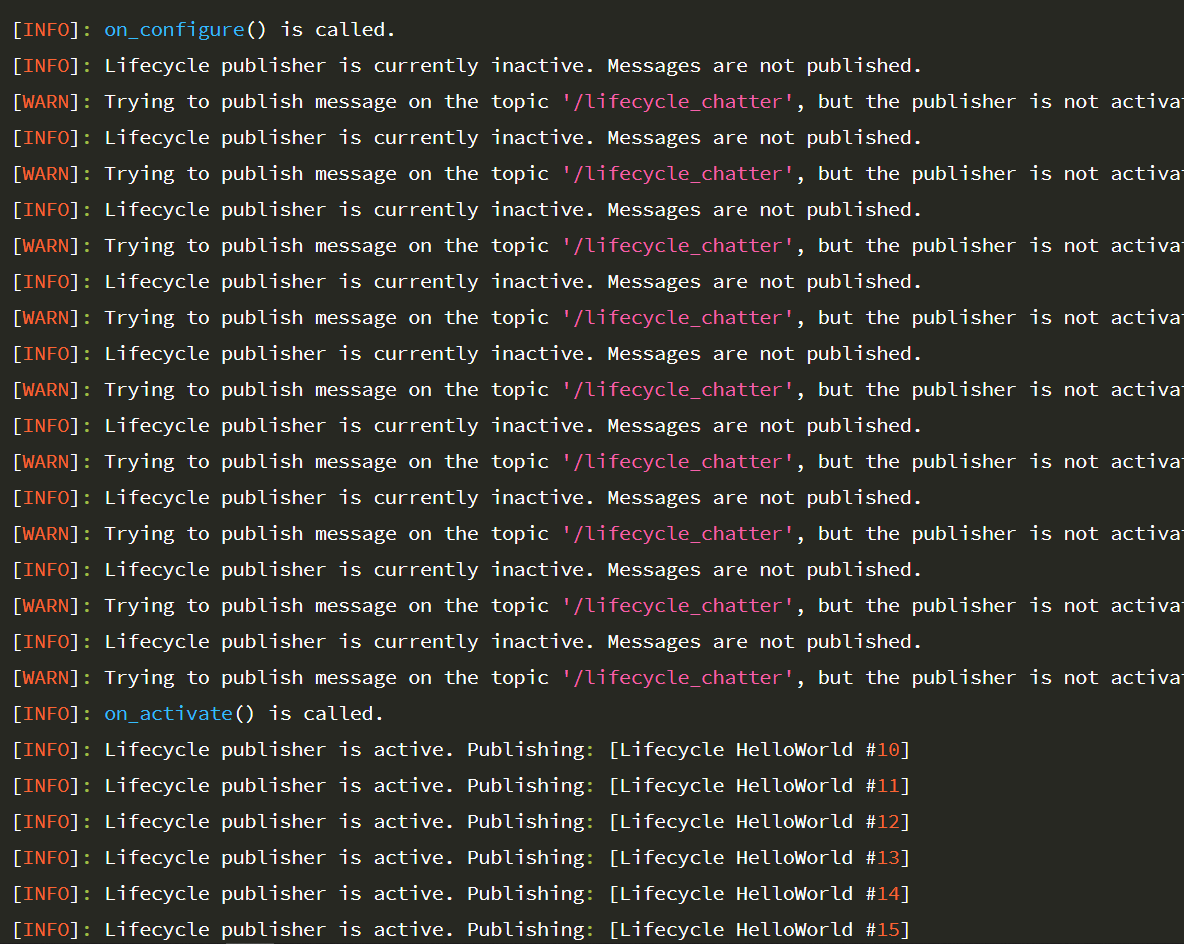

lc_listener 노드는 lc_talker 노드의 상태 전환 이벤트를 확인하여 이를 로그로 보여주고, lc_talker 가 activate 상태일 때 구독하고 있는 데이터를 확인하는 모습을 보여준다.

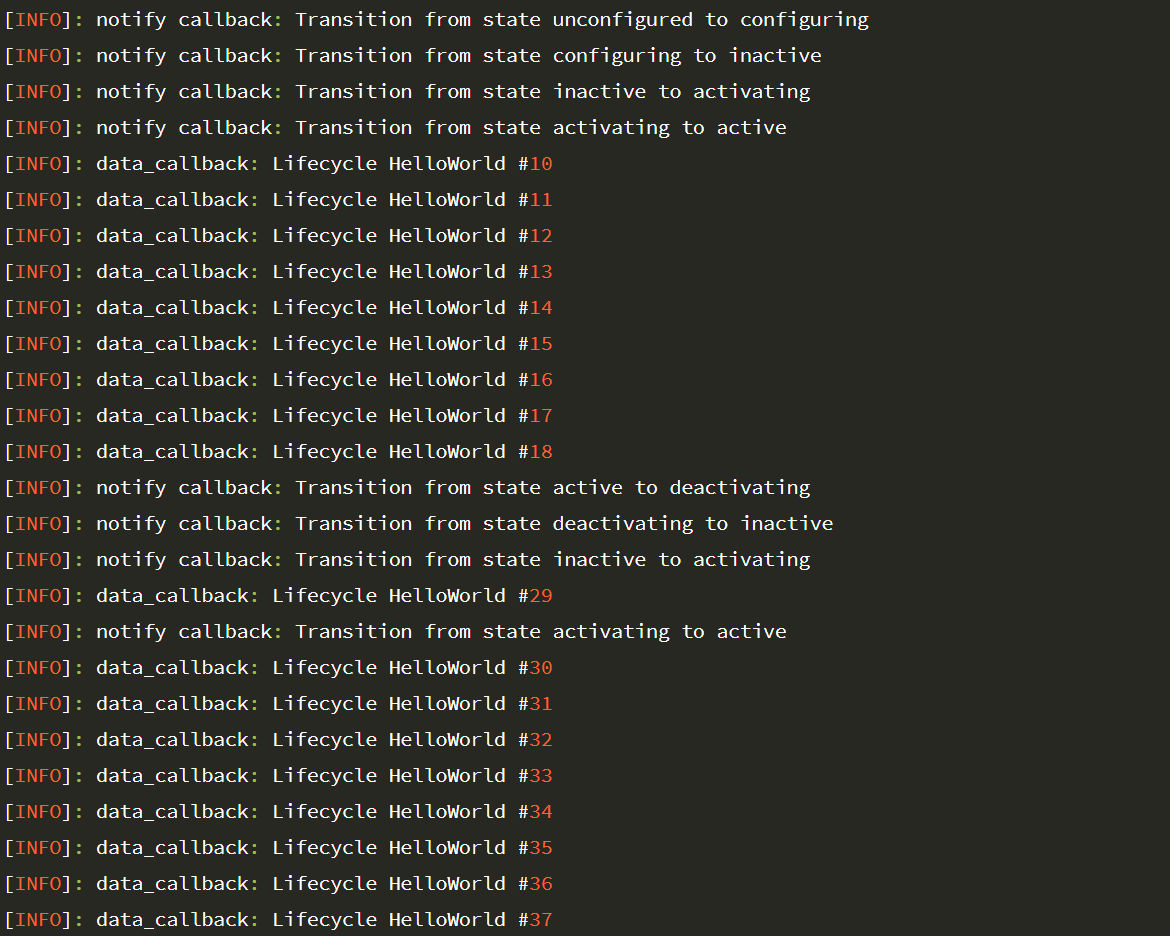

lc_client 노드는 서비스 통신을 통해 lc_talker 의 상태를 전환하고 그 전환 결과를 보여준다.

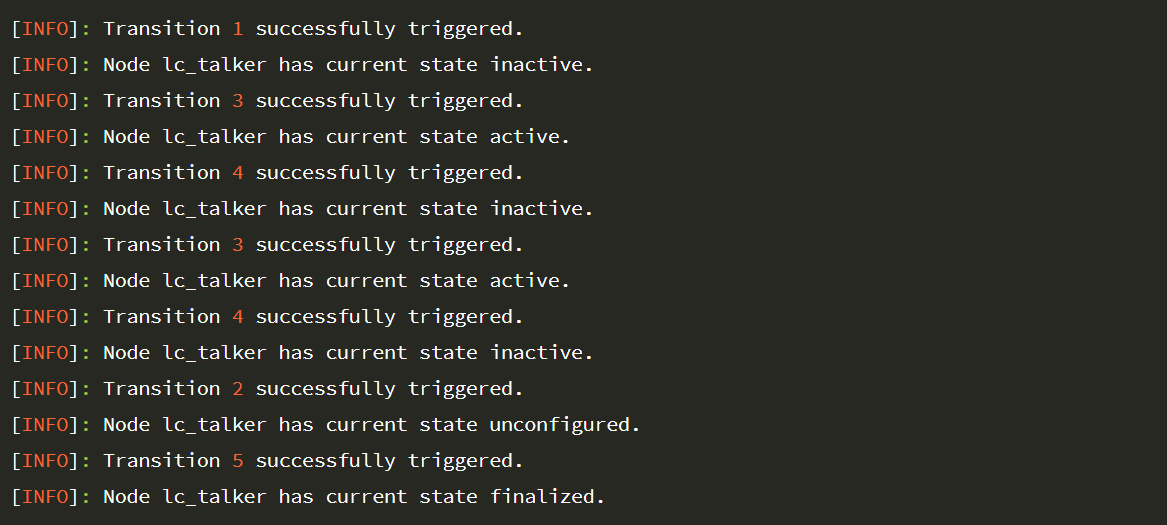